# Feature Engineering and Model Training for Per-Query Optimization

This notebook goes through the process of feature engineering based on the query set used for the global hybrid search optimization notebook.

It tries out different feature combinations and model types to identify a useful way forward towards optimizing queries dynamically.

Notes:

* `searcharray` produced an error with numpy version 2.1.2
* Make sure to use `numpy==1.26.4`

Error fixed in the meantime (not verified)

In [76]:
import pandas as pd
import math
import string
import requests
import json
from searcharray import SearchArray
import numpy as np
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from tqdm.notebook import tqdm_notebook

In [77]:
df_metrics_train = pd.read_csv('../data/metrics_query_train_large_qs-2024-12-03_DCG_fix.csv')
df_metrics_test = pd.read_csv('../data/metrics_query_test_large_qs_all_pipelines-2024-12-03_DCG_fix.csv')
df_metrics = pd.concat([df_metrics_train, df_metrics_test])
df_metrics.reset_index(inplace=True, drop=True)

In [78]:
df_metrics[df_metrics['metric'] == 'ndcg'].head(3)

,query,pipeline,metric,value
264000,#8 tags without string,l2arithmetic_mean0.0,ndcg,0.157726
264001,#8 tags without string,l2arithmetic_mean0.1,ndcg,0.535293
264002,#8 tags without string,l2arithmetic_mean0.2,ndcg,0.535293


In [79]:
df_metrics.sort_values(by='query').head(25)

,query,pipeline,metric,value
0,#8 tags without string,l2arithmetic_mean0.0,dcg,7.902232
528039,#8 tags without string,min_maxarithmetic_mean0.6,prec@10,0.800000
528040,#8 tags without string,min_maxarithmetic_mean0.7,prec@10,0.800000
528041,#8 tags without string,min_maxarithmetic_mean0.8,prec@10,0.900000
528042,#8 tags without string,min_maxarithmetic_mean0.9,prec@10,0.900000
528043,#8 tags without string,min_maxarithmetic_mean1.0,prec@10,0.900000
528044,#8 tags without string,min_maxgeometric_mean0.0,prec@10,0.400000
528045,#8 tags without string,min_maxgeometric_mean0.1,prec@10,0.500000
528038,#8 tags without string,min_maxarithmetic_mean0.5,prec@10,0.800000
528046,#8 tags without string,min_maxgeometric_mean0.2,prec@10,0.500000


In [80]:
# get max NDCG values: best pipeline run per query according to NDCG
indexes = df_metrics[df_metrics['metric'] == 'ndcg'].groupby(by='query')['value'].idxmax()
df_filtered = df_metrics.loc[indexes, ['query','pipeline', 'value']]

In [81]:
df_filtered.sort_values(by='query').head(11)

,query,pipeline,value
264010,#8 tags without string,l2arithmetic_mean1.0,0.536725
264066,$1 dollar toys not fidgets,l2arithmetic_mean0.0,0.000000
264132,$30 roblox gift card not digital,l2arithmetic_mean0.0,0.000000
264198,$60 ps4 that’s not gonna be on amazon,l2arithmetic_mean0.0,0.000000
264264,'m team jesus i'm not religious shirt,l2arithmetic_mean0.0,0.409661
264342,'oh no not you again' door mat,l2geometric_mean0.1,0.205352
264397,(fiction without frontiers),l2arithmetic_mean0.1,0.463643
264462,", funny cat suits are not repeated a week",l2arithmetic_mean0.0,0.000000
1122002,- we are not such things,l2arithmetic_mean0.2,0.631793
264528,.8chinese not court rat tail,l2arithmetic_mean0.0,0.000000


In [82]:
df_filtered.shape[0]

5000

## Get 'neuralness' of a Query

`neuralness` is the weight of the neural query extracted by the pipeline name that was used to generate the NDCG value.

In [83]:
def get_neuralness(pipeline):
    keywordness = pipeline[-3:]

    try:
        neuralness = 1 - float(keywordness)
        return neuralness
    except ValueError:
        print("ERROR")
        return math.nan

In [84]:
df_filtered['neuralness'] = df_filtered.pipeline.apply(get_neuralness)

In [85]:
df_filtered = df_filtered.drop(columns=['pipeline'])

In [86]:
df_filtered.columns = ['query_string', 'ndcg', 'neuralness']

In [87]:
df_filtered.head(3)

,query_string,ndcg,neuralness
264010,#8 tags without string,0.536725,0.0
264066,$1 dollar toys not fidgets,0.000000,1.0
264132,$30 roblox gift card not digital,0.000000,1.0


## Query Feature Functions

`num_of_terms`: we expect the number of query terms to be a good feature because the more query terms used the more specific a query is.

`query_length`: we expect the query length (number of characters) to be a good feature because the longer a query is the more specific it is.

`has_numbers`: we expect the presence of numbers/digits to be a good feature because numbers may point towards specific queries.

`has_special_char`: we expect the presence of special characters (non-alphanumeric characters) to be a good feature because that may point towards specific queries. 

In [88]:
def num_of_terms(query_string):
    terms = query_string.split(" ")
    return len(terms)

def query_length(query_string):
    return len(query_string)

def has_numbers(query_string):
    return int(any(char.isdigit() for char in query_string))

def has_special_char(query_string):
    # Define special characters (all non-alphanumeric characters)
    special_chars = string.punctuation
    # Return True if any character in the string is a special character
    return int(any(char in special_chars for char in query_string))

In [89]:
df_filtered['num_of_terms'] = df_filtered.query_string.apply(num_of_terms)
df_filtered['query_length'] = df_filtered.query_string.apply(query_length)
df_filtered['has_numbers'] = df_filtered.query_string.apply(has_numbers)
df_filtered['has_special_char'] = df_filtered.query_string.apply(has_special_char)

In [90]:
df_filtered.head(5)

,query_string,ndcg,neuralness,num_of_terms,query_length,has_numbers,has_special_char
264010,#8 tags without string,0.536725,0.0,4,22,1,1
264066,$1 dollar toys not fidgets,0.000000,1.0,5,26,1,1
264132,$30 roblox gift card not digital,0.000000,1.0,6,32,1,1
264198,$60 ps4 that’s not gonna be on amazon,0.000000,1.0,8,37,1,1
264264,'m team jesus i'm not religious shirt,0.409661,1.0,7,37,0,1


## Result Feature Functions

`num_results_kw_search`: the number of results for the keyword query.

`max_doc_score`: max score of the retrieved top 10 titles. The scores are BM25 scores calculated individually per result set. That means that the document frequencies of terms is not calculated on the whole index but only on the retrieved subset for the query, making the scores more comparable to each other.

`sum_of_doc_scores`: we use the sum of the scores (and no average value) as an aggregate to have a measure of how relevant all retrieved top 10 titles are.

`get_semantic_scores_for_query`: retrieves the semantic scores for the neural query for the top 10. We store the maximum and the mean as result features.

### Helper functions

`get_titles_for_query`: retrieves the titles of the keyword matches for later score calculation

`whitespace_to_lower`: tokenizes and lowercases text

`get_model_id`: to run a neural search to get the semantic scores we need to know the id of the available model in OpenSearch


### Get Number of Results for Keyword Search

In [91]:
def num_results_kw_search(query_string):
    url = "http://localhost:9200/ecommerce/_search"

    headers = {
        'Content-Type': 'application/json'
    }
    
    
    
    payload = {
      "_source": {
        "excludes": [
          "title_embedding"
        ]
      },
      "query": {
        "multi_match" : {
          "type":       "best_fields",
          "fields":     [
            "product_id^100",
            "product_bullet_point^3",
            "product_color^2",
            "product_brand^5",
            "product_description",
            "product_title^10"
          ],
          "operator":   "and",
          "query":      query_string
        }
      },
      "track_total_hits": "true"
    }
    response = requests.request("POST", url, headers=headers, data=json.dumps(payload)).json()
    num_results = response['hits']['total']['value']
    return num_results

In [92]:
def get_titles_for_query(query_string):
    url = "http://localhost:9200/ecommerce/_search"

    headers = {
        'Content-Type': 'application/json'
    }
      
    payload = {
      "_source": {
        "excludes": [
          "title_embedding"
        ],
        "includes": "product_title"
      },
      "query": {
        "multi_match" : {
          "type":       "best_fields",
          "fields":     [
            "product_id^100",
            "product_bullet_point^3",
            "product_color^2",
            "product_brand^5",
            "product_description",
            "product_title^10"
          ],
          "operator":   "and",
          "query":      query_string
        }
      },
      "track_total_hits": "true"
    }
    response = requests.request("POST", url, headers=headers, data=json.dumps(payload)).json()
    titles = []
    num_results = response['hits']['total']['value']
    if num_results > 0:
        # get all titles
        titles = [item['_source']['product_title'] for item in response['hits']['hits']]

    df = pd.DataFrame(titles, columns=['title'])

    return df

In [93]:
tqdm_notebook.pandas()
df_filtered['num_results'] = df_filtered.query_string.progress_apply(num_results_kw_search)

  0%|          | 0/5000 [00:00<?, ?it/s]

### Tokenizer Definition

We define a simple tokenizer that splits on whitespaces and lowercases.

In [94]:
def whitespace_to_lower(text):
    split = text.lower().split()
    return [token
        for token in split]

ToDo: make the following functions more efficient.

The following functions contain redundant code and only differ in the return value.

In [95]:
# we use searcharray to calculate the highest title score among the retrieved docs
def max_doc_score(df, query):
    # if we retrieved zero docs we return 0 as the max score
    if df.shape[0] == 0:
        return 0
    else:
        # index the titles with the defined tokenizer
        df['title_indexed'] = SearchArray.index(df['title'], tokenizer=whitespace_to_lower)
        # tokenize the query with the same tokenizer
        tokenized_query = df['title_indexed'].array.tokenizer(query)
        # calculate the score for each query term
        # the result is a matrix with number of titles x number of query term dimensions
        scores = np.asarray([df['title_indexed'].array.score(query_term)
                                    for query_term in tokenized_query])
        # calculate the sum of all query terms per title
        sums = [sum(group) for group in zip(*scores)]
        # return the maximum
        return max(sums)

# we use searcharray to calculate the sum of all title scores among the retrieved docs
def sum_of_doc_scores(df, query):
    # if we retrieved zero docs we return 0 as the max score
    if df.shape[0] == 0:
        return 0
    else:
        # index the titles with the defined tokenizer
        df['title_indexed'] = SearchArray.index(df['title'], tokenizer=whitespace_to_lower)
        # tokenize the query with the same tokenizer
        tokenized_query = df['title_indexed'].array.tokenizer(query)
        # calculate the score for each query term
        # the result is a matrix with number of titles x number of query term dimensions
        scores = np.asarray([df['title_indexed'].array.score(query_term)
                                    for query_term in tokenized_query])
        # calculate the sum of all query terms per title
        sums = [sum(group) for group in zip(*scores)]
        # return the sum of all title scores
        return sum(sums)

### Get Semantic Scores

First we get the model id, then we use the model id in the query to retrieve the semantic scores.

In [96]:
# Get model_id
# We are assuming that the installation has only one model. Change this if you have more models 
# and need to pick a specific one

def get_model_id():
    url = "http://localhost:9200/_plugins/_ml/models/_search"
    
    headers = {
        'Content-Type': 'application/json'
    }
    
    payload = {
      "query": {
        "match_all": {}
      },
      "size": 1
    }
    
    response = requests.request("POST", url, headers=headers, data=json.dumps(payload))

    return response.json()['hits']['hits'][0]['_source']['model_id']

model_id = get_model_id()

In [97]:
def get_semantic_scores_for_query(query_string):
    url = "http://localhost:9200/ecommerce/_search"

    headers = {
        'Content-Type': 'application/json'
    }
    
    
    
    payload = {
      "_source": {
        "excludes": [
          "title_embedding"
        ],
        "includes": "product_title"
      },
      "query": {
        "neural": {
          "title_embedding": {
            "query_text": query_string,
            "k": 100,
            "model_id": model_id
          }
        }
      },
      "size": 10
    }
    response = requests.request("POST", url, headers=headers, data=json.dumps(payload)).json()
    titles = []
    num_results = response['hits']['total']['value']
    if num_results > 0:
        # get all titles
        scores = [item['_score'] for item in response['hits']['hits']]

    return scores

In [98]:
import logging, sys
logging.disable(sys.maxsize)

In [99]:
tqdm_notebook.pandas()
df_filtered['max_title_score'] = df_filtered['query_string'].progress_apply(lambda q: max_doc_score(get_titles_for_query(q), q))
df_filtered['sum_title_scores'] = df_filtered['query_string'].progress_apply(lambda q: sum_of_doc_scores(get_titles_for_query(q), q))

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [100]:
tqdm_notebook.pandas()
df_filtered['max_semantic_score'] = df_filtered['query_string'].progress_apply(lambda q: max(get_semantic_scores_for_query(q)))
df_filtered['avg_semantic_score'] = df_filtered['query_string'].progress_apply(lambda q: np.mean(get_semantic_scores_for_query(q)))

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [101]:
df_filtered.head(5)

,query_string,ndcg,neuralness,num_of_terms,query_length,has_numbers,has_special_char,num_results,max_title_score,sum_title_scores,max_semantic_score,avg_semantic_score
264010,#8 tags without string,0.536725,0.0,4,22,1,1,14,0.196224,1.427612,0.485108,0.476736
264066,$1 dollar toys not fidgets,0.000000,1.0,5,26,1,1,3,0.225544,0.415382,0.608848,0.593169
264132,$30 roblox gift card not digital,0.000000,1.0,6,32,1,1,0,0.000000,0.000000,0.697739,0.654398
264198,$60 ps4 that’s not gonna be on amazon,0.000000,1.0,8,37,1,1,0,0.000000,0.000000,0.544553,0.528364
264264,'m team jesus i'm not religious shirt,0.409661,1.0,7,37,0,1,0,0.000000,0.000000,0.891805,0.840608


In [102]:
df_filtered.columns

Index(['query_string', 'ndcg', 'neuralness', 'num_of_terms', 'query_length',
       'has_numbers', 'has_special_char', 'num_results', 'max_title_score',
       'sum_title_scores', 'max_semantic_score', 'avg_semantic_score'],
      dtype='object')

In [103]:
# rename the columns
df_filtered = df_filtered.rename(columns={"neuralness": "f_0_neuralness",
                            "num_of_terms": "f_1_num_of_terms",
                            "query_length": "f_2_query_length",
                            "has_numbers": "f_3_has_numbers",
                            "has_special_char": "f_4_has_special_char",
                            "num_results": "f_5_num_results",
                            "max_title_score": "f_6_max_title_score",
                            "sum_title_scores": "f_7_sum_title_scores",
                            "max_semantic_score": "f_8_max_semantic_score",
                            "avg_semantic_score": "f_9_avg_semantic_score"
                           })

In [104]:
df_filtered.head(5)

,query_string,ndcg,f_0_neuralness,f_1_num_of_terms,f_2_query_length,f_3_has_numbers,f_4_has_special_char,f_5_num_results,f_6_max_title_score,f_7_sum_title_scores,f_8_max_semantic_score,f_9_avg_semantic_score
264010,#8 tags without string,0.536725,0.0,4,22,1,1,14,0.196224,1.427612,0.485108,0.476736
264066,$1 dollar toys not fidgets,0.000000,1.0,5,26,1,1,3,0.225544,0.415382,0.608848,0.593169
264132,$30 roblox gift card not digital,0.000000,1.0,6,32,1,1,0,0.000000,0.000000,0.697739,0.654398
264198,$60 ps4 that’s not gonna be on amazon,0.000000,1.0,8,37,1,1,0,0.000000,0.000000,0.544553,0.528364
264264,'m team jesus i'm not religious shirt,0.409661,1.0,7,37,0,1,0,0.000000,0.000000,0.891805,0.840608


In [105]:
# Uncomment the thing you want to do

# write features if they're initially computed
df_filtered.to_csv('../data/features_query_set_large_all_queries_ndcg_as_feature-2024-12-03_DCG_fix.csv', index=False)
# get features if they're already present and you run the training process from here
#df_filtered = pd.read_csv('../data/features_query_set_small_all_queries_ndcg_as_feature.csv')

# Explore Different Model Training Options

We try out linear regression and random forest regression as two types of models.

We want to find out which feature combination is best by trying out all different combinations.

We apply cross validation for a statistically sound process.

We explore the effect of adding regularization to reduce the change of overfitting.

## Linear Regression with Feature Combinations and Cross Validation

In [106]:
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, root_mean_squared_error, r2_score
from itertools import combinations
import numpy as np
import pandas as pd

# Prepare features and target
feature_columns = [ "f_0_neuralness", "f_1_num_of_terms", "f_2_query_length", "f_3_has_numbers", "f_4_has_special_char", "f_5_num_results",
                   "f_6_max_title_score", "f_7_sum_title_scores", "f_8_max_semantic_score",  "f_9_avg_semantic_score"]
kws_features = ["f_5_num_results", "f_6_max_title_score", "f_7_sum_title_scores"]
neural_search_features = ["f_8_max_semantic_score",  "f_9_avg_semantic_score"]
query_features = ["f_1_num_of_terms",  "f_2_query_length", "f_3_has_numbers", "f_4_has_special_char"]
y = df_filtered['ndcg']  # Target column

# Initialize cross-validation strategy
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

# Define the model
regr = LinearRegression()

rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

# Initialize variables to track the best combination
best_score = float('inf')
best_combination = None
best_metrics = {}
# We initialize df_metrics only for this run and append the results of the following runs
df_model = []
# Initialize df_model_metrics to collect metrics for this iteration of model training
df_model_metrics = []

# Try all feature combinations of length 2 to 9
for r in tqdm_notebook(range(2, len(feature_columns) + 1)):
    for combo in combinations(feature_columns, r):
        X = df_filtered[list(combo)]  # Select current feature subset
        
        # Perform cross-validation
        rmse_scores = cross_val_score(regr, X, y, cv=cv, scoring=rmse_scorer)
        
        # Calculate the mean metrics for the current combination
        mean_rmse = -np.mean(rmse_scores)  # Since RMSE scorer is negative for minimization

        # does the current combination contain keyword search features
        keyword_b = any(feature in combo for feature in kws_features)
        # does the current combination contain neural search features
        neural_b = any(feature in combo for feature in neural_search_features)
        # does the current combination contain only query features (no keyword or neural search features)
        query_b = any(feature in combo for feature in query_features)
        
        df_model_metrics.append(pd.DataFrame({
            "features": [combo]*5,
            "rmse_scores": rmse_scores,
            "keyword_f": [keyword_b]*5,
            "neural_f": [neural_b]*5,
            "query_f": [query_b]*5,
            "model": "lr",
            "regularization": False,
            }))
        
        # Update if the current combination is better
        if mean_rmse < best_score:
            best_score = mean_rmse
            best_combination = combo
            best_metrics = {
                'RMSE (mean)': mean_rmse
            }

df_metrics = pd.concat(df_model_metrics)

# Output the best feature combination and its metrics
print("Best Feature Combination:", best_combination)
print("Best Metrics:")
print(f"Cross-Validation RMSE (mean): {best_metrics['RMSE (mean)']}")

  0%|          | 0/9 [00:00<?, ?it/s]

Best Feature Combination: ('f_0_neuralness', 'f_1_num_of_terms', 'f_2_query_length', 'f_3_has_numbers', 'f_4_has_special_char', 'f_5_num_results', 'f_6_max_title_score', 'f_7_sum_title_scores', 'f_8_max_semantic_score', 'f_9_avg_semantic_score')
Best Metrics:
Cross-Validation RMSE (mean): 0.22510185387128426


## Linear Regression with Feature Combinations, Cross Validation and L2 Regularization

### Find best regularization parameter

Use all features, get the "best" regularization parameter with cross-validation by trying out a range

In [107]:
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer, root_mean_squared_error, r2_score
from itertools import combinations
import numpy as np
import pandas as pd

# Prepare features and target
feature_columns = [ "f_0_neuralness", "f_1_num_of_terms", "f_2_query_length", "f_3_has_numbers", "f_4_has_special_char", "f_5_num_results",
                   "f_6_max_title_score", "f_7_sum_title_scores", "f_8_max_semantic_score",  "f_9_avg_semantic_score"]
kws_features = ["f_5_num_results", "f_6_max_title_score", "f_7_sum_title_scores"]
neural_search_features = ["f_8_max_semantic_score",  "f_9_avg_semantic_score"]
query_features = ["f_1_num_of_terms",  "f_2_query_length", "f_3_has_numbers", "f_4_has_special_char"]
y = df_filtered['ndcg']  # Target column

# Initialize cross-validation strategy
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

# Define alpha values to test in regularization
alpha_vals = [0.001, 0.1, 0.2, 0.5, 1.0, 1.5, 2.0, 5.0, 10.0]

# Initialize variables to track the best combination
best_metrics = {}
best_score = float('inf')
for alpha in alpha_vals:
    
    # Define the model
    regr = Ridge(alpha=alpha)

    rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

    X = df_filtered[feature_columns]  # Select current feature subset
    
    # Perform cross-validation
    rmse_scores = cross_val_score(regr, X, y, cv=cv, scoring=rmse_scorer)
    
    mean_rmse = -np.mean(rmse_scores)  # Since RMSE scorer is negative for minimization
        
    # Update if the current combination is better
    if mean_rmse < best_score:
        print(f"Found lower mean RMSE ({mean_rmse}) for alpha value of {alpha}")
        best_score = mean_rmse
        best_metrics = {
            'alpha': alpha,
            'RMSE (mean)': best_score
        }

# Output the best feature combination and its metrics
print("Best Metrics:")
#print(f"Accuracy (mean): {best_metrics['Accuracy (mean)']}")
print(f"alpha: {best_metrics['alpha']}")
print(f"Cross-Validation RMSE (mean): {best_metrics['RMSE (mean)']}")

Found lower mean RMSE (0.22510192683220595) for alpha value of 0.001
Best Metrics:
alpha: 0.001
Cross-Validation RMSE (mean): 0.22510192683220595


In [108]:
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer, root_mean_squared_error, r2_score
from itertools import combinations
import numpy as np
import pandas as pd

# Prepare features and target
feature_columns = [ "f_0_neuralness", "f_1_num_of_terms", "f_2_query_length", "f_3_has_numbers", "f_4_has_special_char", "f_5_num_results",
                   "f_6_max_title_score", "f_7_sum_title_scores", "f_8_max_semantic_score",  "f_9_avg_semantic_score"]
kws_features = ["f_5_num_results", "f_6_max_title_score", "f_7_sum_title_scores"]
neural_search_features = ["f_8_max_semantic_score",  "f_9_avg_semantic_score"]
query_features = ["f_1_num_of_terms",  "f_2_query_length", "f_3_has_numbers", "f_4_has_special_char"]
y = df_filtered['ndcg']  # Target column

# Initialize cross-validation strategy
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

# Define the model
regr = Ridge(alpha=alpha)

rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

# Initialize variables to track the best combination
best_score = float('inf')
best_combination = None
best_metrics = {}
df_model_metrics = []

# Try all feature combinations of length 2 to 9
for r in tqdm_notebook(range(2, len(feature_columns) + 1)):
    for combo in combinations(feature_columns, r):
        X = df_filtered[list(combo)]  # Select current feature subset
        
        # Perform cross-validation
        rmse_scores = cross_val_score(regr, X, y, cv=cv, scoring=rmse_scorer)
        
        # Calculate the mean metrics for the current combination
        mean_rmse = -np.mean(rmse_scores)  # Since RMSE scorer is negative for minimization

        # does the current combination contain keyword search features
        keyword_b = any(feature in combo for feature in kws_features)
        # does the current combination contain neural search features
        neural_b = any(feature in combo for feature in neural_search_features)
        # does the current combination contain only query features (no keyword or neural search features)
        query_b = any(feature in combo for feature in query_features)

        df_model_metrics.append(pd.DataFrame({
            "features": [combo]*5,
            "rmse_scores": rmse_scores,
            "keyword_f": [keyword_b]*5,
            "neural_f": [neural_b]*5,
            "query_f": [query_b]*5,
            "model": "lr",
            "regularization": True,
            }))
        
        # Update if the current combination is better
        if mean_rmse < best_score:
            best_score = mean_rmse
            best_combination = combo
            best_metrics = {
                'RMSE (mean)': mean_rmse
            }

df_metrics = pd.concat([df_metrics, pd.concat(df_model_metrics)])

# Output the best feature combination and its metrics
print("Best Feature Combination:", best_combination)
print("Best Metrics:")
print(f"Cross-Validation RMSE (mean): {best_metrics['RMSE (mean)']}")

  0%|          | 0/9 [00:00<?, ?it/s]

Best Feature Combination: ('f_0_neuralness', 'f_1_num_of_terms', 'f_4_has_special_char', 'f_5_num_results', 'f_6_max_title_score', 'f_7_sum_title_scores', 'f_8_max_semantic_score', 'f_9_avg_semantic_score')
Best Metrics:
Cross-Validation RMSE (mean): 0.2293934241857852


## Random Forest Regression with Feature Combinations and Cross Validation

In [109]:
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, root_mean_squared_error, r2_score
from itertools import combinations
import numpy as np
import pandas as pd

# Prepare features and target
feature_columns = [ "f_0_neuralness", "f_1_num_of_terms", "f_2_query_length", "f_3_has_numbers", "f_4_has_special_char", "f_5_num_results",
                   "f_6_max_title_score", "f_7_sum_title_scores", "f_8_max_semantic_score",  "f_9_avg_semantic_score"]
kws_features = ["f_5_num_results", "f_6_max_title_score", "f_7_sum_title_scores"]
neural_search_features = ["f_8_max_semantic_score",  "f_9_avg_semantic_score"]
query_features = ["f_1_num_of_terms",  "f_2_query_length", "f_3_has_numbers", "f_4_has_special_char"]

y = df_filtered['ndcg']  # Target column

# Initialize cross-validation strategy
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

# Define the model
model = RandomForestRegressor(random_state=42)

rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

# Initialize variables to track the best combination
best_score = float('inf')
best_combination = None
best_metrics = {}
df_model_metrics = []

# Try all feature combinations of length 2 to 9
for r in tqdm_notebook(range(2, len(feature_columns) + 1)):
    for combo in combinations(feature_columns, r):
        X = df_filtered[list(combo)]  # Select current feature subset
        
        # Perform cross-validation
        scores = cross_val_score(model, X, y, cv=cv)
        rmse_scores = cross_val_score(model, X, y, cv=cv, scoring=rmse_scorer)
        
        # Calculate the mean metrics for the current combination
        mean_score = scores.mean()
        std_score = scores.std()
        mean_rmse = -np.mean(rmse_scores)  # Since RMSE scorer is negative for minimization

        # does the current combination contain keyword search features
        keyword_b = any(feature in combo for feature in kws_features)
        # does the current combination contain neural search features
        neural_b = any(feature in combo for feature in neural_search_features)
        # does the current combination contain query features
        query_b = any(feature in combo for feature in query_features)
        
        df_model_metrics.append(pd.DataFrame({
            "features": [combo]*5,
            "rmse_scores": rmse_scores,
            "keyword_f": [keyword_b]*5,
            "neural_f": [neural_b]*5,
            "query_f": [query_b]*5,
            "model": "rf",
            "regularization": False,
            }))
        # Update if the current combination is better
        if mean_rmse < best_score:
            best_score = mean_rmse
            best_combination = combo
            best_metrics = {
                'RMSE (mean)': mean_rmse
            }

df_metrics = pd.concat([df_metrics, pd.concat(df_model_metrics)])

# Output the best feature combination and its metrics
print("Best Feature Combination:", best_combination)
print("Best Metrics:")
print(f"Cross-Validation RMSE (mean): {best_metrics['RMSE (mean)']}")

  0%|          | 0/9 [00:00<?, ?it/s]

Best Feature Combination: ('f_0_neuralness', 'f_1_num_of_terms', 'f_2_query_length', 'f_3_has_numbers', 'f_4_has_special_char', 'f_5_num_results', 'f_6_max_title_score', 'f_7_sum_title_scores', 'f_8_max_semantic_score', 'f_9_avg_semantic_score')
Best Metrics:
Cross-Validation RMSE (mean): 0.18490692598263297


## Random Forest Regression with Feature Combinations, Cross Validation and Regularization (RandomizedSearchCV)

In [110]:
# RandomizedSearchCV is very verbose in logging warnings. The following snippet suppresses these.
# source: https://stackoverflow.com/questions/32612180/eliminating-warnings-from-scikit-learn
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [111]:
from sklearn.model_selection import ShuffleSplit, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, root_mean_squared_error, r2_score
from itertools import combinations
import numpy as np
import pandas as pd

# Prepare features and target
feature_columns = [ "f_0_neuralness", "f_1_num_of_terms", "f_2_query_length", "f_3_has_numbers", "f_4_has_special_char", "f_5_num_results",
                   "f_6_max_title_score", "f_7_sum_title_scores", "f_8_max_semantic_score",  "f_9_avg_semantic_score"]
kws_features = ["f_5_num_results", "f_6_max_title_score", "f_7_sum_title_scores"]
neural_search_features = ["f_8_max_semantic_score",  "f_9_avg_semantic_score"]
query_features = ["f_1_num_of_terms",  "f_2_query_length", "f_3_has_numbers", "f_4_has_special_char"]

y = df_filtered['ndcg']  # Target column

# Initialize cross-validation strategy
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

# Define Random Forest hyperparameter distributions for RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [1, 2, 3, 5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

# Initialize variables to track the best combination
best_score = float('inf')
best_combination = None
best_metrics = {}
df_model_metrics = []

# Try all feature combinations of length 2 to 9
#for r in tqdm_notebook(range(2, len(feature_columns) + 1)):
for r in range(2, len(feature_columns) + 1):
    for combo in combinations(feature_columns, r):
        X = df_filtered[list(combo)]  # Select current feature subset

        # Define the model
        model = RandomForestRegressor(random_state=42)
        # Initialize RandomizedSearchCV
        random_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_dist,
            n_iter=10,  # Number of random samples to draw
            scoring=rmse_scorer,
            cv=cv,
            random_state=42,
            n_jobs=-1,
            verbose=0
        )

        # Perform cross-validation with randomized hyperparameter search
        random_search.fit(X, y)

        # Get the best score and parameters from the random search
        mean_rmse = -random_search.best_score_  # Convert to positive RMSE
        best_params = random_search.best_params_

        # Retrieve mean_test_score and mask out NaNs
        mean_test_scores = -random_search.cv_results_["mean_test_score"]
        valid_scores = np.where(~np.isnan(mean_test_scores), mean_test_scores, np.inf)  # Replace NaNs with infinity
        
        # Find the index of the best configuration based on valid mean_test_scores
        best_config_index = np.argmin(valid_scores)
        
        # Retrieve individual fold scores for the best configuration
        best_fold_scores = []
        for fold_index in range(5):  # 5 folds
            # Get the score for the current fold of the best configuration
            score = random_search.cv_results_[f"split{fold_index}_test_score"][best_config_index]
            best_fold_scores.append(score)

        # does the current combination contain keyword search features
        keyword_b = any(feature in combo for feature in kws_features)
        # does the current combination contain neural search features
        neural_b = any(feature in combo for feature in neural_search_features)
        # does the current combination contain query features
        query_b = any(feature in combo for feature in query_features)

        df_model_metrics.append(pd.DataFrame({
            "features": [combo]*5,
            "rmse_scores": best_fold_scores,
            "keyword_f": [keyword_b]*5,
            "neural_f": [neural_b]*5,
            "query_f": [query_b]*5,
            "model": "rf",
            "regularization": True,
            }))
        
        # Update if the current combination is better
        if mean_rmse < best_score:
            best_score = mean_rmse
            best_combination = combo
            best_param_set = best_params
            best_metrics = {
                'RMSE (mean)': mean_rmse
            }

df_metrics = pd.concat([df_metrics, pd.concat(df_model_metrics)])

# Output the best feature combination and its metrics
print("Best Feature Combination:", best_combination)
print("Best Parameter Set:", best_param_set)
print("Best Metrics:")
print(f"Cross-Validation RMSE (mean): {best_metrics['RMSE (mean)']}")

Best Feature Combination: ('f_0_neuralness', 'f_1_num_of_terms', 'f_2_query_length', 'f_4_has_special_char', 'f_5_num_results', 'f_6_max_title_score', 'f_8_max_semantic_score', 'f_9_avg_semantic_score')
Best Parameter Set: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10}
Best Metrics:
Cross-Validation RMSE (mean): 0.1802348378919012


### Aggregate Metrics per Model, Regularization, and Feature Combination

In [112]:
# multiply rmse scores by -1 as they are all negative for minimization
df_metrics['rmse_scores'] = df_metrics['rmse_scores'] * (-1)

In [113]:
# join features to a feature string
df_metrics['features'] =  df_metrics.features.apply(lambda x: ','.join(x))

In [114]:
df_agg_metrics = df_metrics.groupby(by=['features', 'keyword_f', 'neural_f', 'query_f', 'model', 'regularization']).agg({
    'rmse_scores': ['mean', 'var', np.std]
}).reset_index()
df_agg_metrics.columns = ['features', 'keyword_f', 'neural_f', 'query_f', 'model', 'regularization', 'mean_rmse', 'var_rmse', 'std_rmse']


In [115]:
df_agg_metrics.head(5)

,features,keyword_f,neural_f,query_f,model,regularization,mean_rmse,var_rmse,std_rmse
0,"f_0_neuralness,f_1_num_of_terms",False,False,True,lr,False,0.241387,0.000027,0.005204
1,"f_0_neuralness,f_1_num_of_terms",False,False,True,lr,True,0.241419,0.000027,0.005172
2,"f_0_neuralness,f_1_num_of_terms",False,False,True,rf,False,0.224743,0.000014,0.003749
3,"f_0_neuralness,f_1_num_of_terms",False,False,True,rf,True,0.223422,0.000016,0.004025
4,"f_0_neuralness,f_1_num_of_terms,f_2_query_length",False,False,True,lr,False,0.241299,0.000028,0.005296


In [116]:
# 10 best feature combinations across all experiments
df_agg_metrics.sort_values(by='mean_rmse').head(10)

,features,keyword_f,neural_f,query_f,model,regularization,mean_rmse,var_rmse,std_rmse
299,"f_0_neuralness,f_1_num_of_terms,f_2_query_leng...",True,True,True,rf,True,0.180235,0.000010,0.003238
1307,"f_0_neuralness,f_2_query_length,f_4_has_specia...",True,True,True,rf,True,0.180261,0.000015,0.003897
795,"f_0_neuralness,f_1_num_of_terms,f_4_has_specia...",True,True,True,rf,True,0.180333,0.000011,0.003368
411,"f_0_neuralness,f_1_num_of_terms,f_2_query_leng...",True,True,True,rf,True,0.180432,0.000016,0.004034
1443,"f_0_neuralness,f_2_query_length,f_5_num_result...",True,True,True,rf,True,0.180526,0.000012,0.003438
171,"f_0_neuralness,f_1_num_of_terms,f_2_query_leng...",True,True,True,rf,True,0.180632,0.000015,0.003822
1179,"f_0_neuralness,f_2_query_length,f_3_has_number...",True,True,True,rf,True,0.180636,0.000016,0.004051
1067,"f_0_neuralness,f_2_query_length,f_3_has_number...",True,True,True,rf,True,0.180637,0.000014,0.003762
287,"f_0_neuralness,f_1_num_of_terms,f_2_query_leng...",True,True,True,rf,True,0.180660,0.000014,0.003704
1055,"f_0_neuralness,f_2_query_length,f_3_has_number...",True,True,True,rf,True,0.180693,0.000015,0.003890


In [117]:
# 10 worst feature combinations across all experiments
df_agg_metrics.sort_values(by='mean_rmse', ascending=False).head(10)

,features,keyword_f,neural_f,query_f,model,regularization,mean_rmse,var_rmse,std_rmse
3822,"f_3_has_numbers,f_9_avg_semantic_score",False,True,True,rf,False,0.293683,0.000009,0.003055
3946,"f_4_has_special_char,f_9_avg_semantic_score",False,True,True,rf,False,0.293643,0.000006,0.002403
3698,"f_3_has_numbers,f_4_has_special_char,f_9_avg_s...",False,True,True,rf,False,0.292509,0.000017,0.004150
3890,"f_4_has_special_char,f_6_max_title_score",True,False,True,rf,False,0.284267,0.000008,0.002800
3766,"f_3_has_numbers,f_6_max_title_score",True,False,True,rf,False,0.282058,0.000021,0.004557
3642,"f_3_has_numbers,f_4_has_special_char,f_6_max_t...",True,False,True,rf,False,0.281732,0.000017,0.004172
3062,"f_1_num_of_terms,f_9_avg_semantic_score",False,True,True,rf,False,0.281670,0.000011,0.003282
2810,"f_1_num_of_terms,f_3_has_numbers,f_9_avg_seman...",False,True,True,rf,False,0.280674,0.000015,0.003858
2938,"f_1_num_of_terms,f_4_has_special_char,f_9_avg_...",False,True,True,rf,False,0.279933,0.000011,0.003256
3938,"f_4_has_special_char,f_8_max_semantic_score",False,True,True,rf,False,0.279631,0.000005,0.002295


### Visualization

In [118]:
pio.renderers.default = 'plotly_mimetype'
x = df_agg_metrics.sort_values(by='mean_rmse')['features'].head(10)

fig = px.box(df_metrics[df_metrics['features'].isin(x)], x='features',
             y='rmse_scores', title='RMSE Boxplot of Top 10 Feature Combinations')
fig.update_layout(height=800, width=1100,
                  title_text="Top 10 Feature Combinations",
                  xaxis_title="feature combinations", yaxis_title="rmse scores")
fig.update_xaxes(showticklabels=False)
fig.show()

#### Best Linear Models

In [119]:
x = df_agg_metrics[df_agg_metrics['model'] == 'lr'].sort_values(by='mean_rmse')['features'].head(10)

fig = px.box(df_metrics[(df_metrics['features'].isin(x)) & (df_metrics['model'] == 'lr')], x='features',
             y='rmse_scores', title='RMSE Boxplot of Top 10 Feature Combinations')
fig.update_layout(height=800, width=1100,
                  title_text="Top 10 Linear Regression Feature Combinations",
                  xaxis_title="feature combinations", yaxis_title="rmse scores")
fig.update_xaxes(showticklabels=False)
fig.show()

#### Best Random Forest Models

In [120]:
x = df_agg_metrics[df_agg_metrics['model'] == 'rf'].sort_values(by='mean_rmse')['features'].head(10)

fig = px.box(df_metrics[(df_metrics['features'].isin(x)) & (df_metrics['model'] == 'rf')], x='features',
             y='rmse_scores', title='RMSE Boxplot of Top 10 Feature Combinations')
fig.update_layout(height=800, width=1100,
                  title_text="Top 10 Random Forest Feature Combinations",
                  xaxis_title="feature combinations", yaxis_title="rmse scores")
fig.update_xaxes(showticklabels=False)
fig.show()

### Show the best feature combinations based on the mean root squared error grouped by the features they include

Groups: contains query features, contains keyword search features, and contains neural search features and best of all

In [121]:
df_agg_metrics['keyword_f_only'] = (df_agg_metrics['keyword_f'] == True) & (df_agg_metrics['neural_f'] == False) & (df_agg_metrics['query_f'] == False)
df_agg_metrics['neural_f_only'] = (df_agg_metrics['keyword_f'] == False) & (df_agg_metrics['neural_f'] == True) & (df_agg_metrics['query_f'] == False)
df_agg_metrics['query_f_only'] = (df_agg_metrics['keyword_f'] == False) & (df_agg_metrics['neural_f'] == False) & (df_agg_metrics['query_f'] == True)


In [122]:
df_agg_metrics.head(3)

,features,keyword_f,neural_f,query_f,model,regularization,mean_rmse,var_rmse,std_rmse,keyword_f_only,neural_f_only,query_f_only
0,"f_0_neuralness,f_1_num_of_terms",False,False,True,lr,False,0.241387,0.000027,0.005204,False,False,True
1,"f_0_neuralness,f_1_num_of_terms",False,False,True,lr,True,0.241419,0.000027,0.005172,False,False,True
2,"f_0_neuralness,f_1_num_of_terms",False,False,True,rf,False,0.224743,0.000014,0.003749,False,False,True


In [123]:
# Create a better readable string to identify the feature combinations
# The string contains 'k' if it contains keyword search features, 'n' if contains neural search features and
# 'q' if it contains query string features

def create_feature_string(row):
    keyword_s = ""
    neural_s = ""
    query_s = ""
    if row.keyword_f == True:
        keyword_s = "k"
    if row.neural_f == True:
        neural_s = "n"
    if row.query_f == True:
        query_s = "q"
    return keyword_s + neural_s + query_s

In [124]:
# create a string as a key of the feature combination
df_metrics['f_str'] = df_metrics.apply(create_feature_string, axis=1)
df_metrics.head(3)

,features,rmse_scores,keyword_f,neural_f,query_f,model,regularization,f_str
0,"f_0_neuralness,f_1_num_of_terms",0.249991,False,False,True,lr,False,q
1,"f_0_neuralness,f_1_num_of_terms",0.241709,False,False,True,lr,False,q
2,"f_0_neuralness,f_1_num_of_terms",0.236949,False,False,True,lr,False,q


### Linear Regression Model: Best Feature Combination Grouped by Feature types 

In [125]:
# Select the best three models that contain query features, neural features, keyword features and the best overall feature combinations
x_query_f = df_agg_metrics[(df_agg_metrics['query_f']==True) & (df_agg_metrics['model'] == 'lr')].sort_values(by='mean_rmse')['features'].head(5).values
x_neural_f = df_agg_metrics[(df_agg_metrics['neural_f']==True) & (df_agg_metrics['model'] == 'lr')].sort_values(by='mean_rmse')['features'].head(5).values
x_keyword_f = df_agg_metrics[(df_agg_metrics['keyword_f']==True) & (df_agg_metrics['model'] == 'lr')].sort_values(by='mean_rmse')['features'].head(5).values

x_all_f = df_agg_metrics[df_agg_metrics['model'] == 'lr'].sort_values(by='mean_rmse')['features'].head(5).values

x = np.concatenate([x_query_f, x_neural_f, x_keyword_f, x_all_f])

In [126]:
fig = px.box(df_metrics[(df_metrics['features'].isin(x)) & (df_metrics['model'] == 'lr')], x='features',
             y='rmse_scores', title='RMSE Boxplot of Best Feature Combinations', color='f_str')
fig.update_layout(height=800, width=1100,
                  title_text="Linear Model - Best Feature Combinations by Feature Types",
                  xaxis_title="feature combinations", yaxis_title="rmse scores")
fig.update_xaxes(showticklabels=False)
fig.show()

In [127]:
x_query_f = df_agg_metrics[(df_agg_metrics['query_f_only']==True) & (df_agg_metrics['model'] == 'lr')].sort_values(by='mean_rmse')['features'].head(3).values
x_neural_f = df_agg_metrics[(df_agg_metrics['neural_f_only']==True) & (df_agg_metrics['model'] == 'lr')].sort_values(by='mean_rmse')['features'].head(3).values
x_keyword_f = df_agg_metrics[(df_agg_metrics['keyword_f_only']==True) & (df_agg_metrics['model'] == 'lr')].sort_values(by='mean_rmse')['features'].head(3).values

x_all_f = df_agg_metrics[df_agg_metrics['model'] == 'lr'].sort_values(by='mean_rmse')['features'].head(3).values

x = np.concatenate([x_query_f, x_neural_f, x_keyword_f, x_all_f])

In [128]:
fig = px.box(df_metrics[(df_metrics['features'].isin(x)) & (df_metrics['model'] == 'lr')], x='features',
             y='rmse_scores', title='RMSE Boxplot of Best Feature Combinations', color='f_str')
fig.update_layout(height=800, width=1100,
                  title_text="Linear Model - Best Feature Combinations within Feature Groups",
                  xaxis_title="feature combinations", yaxis_title="rmse scores")
fig.update_xaxes(showticklabels=False)
fig.show()

### Random Forest Model: Best Feature Combination Grouped by Feature types 

In [129]:
# Select the best three models that contain query features, neural features, keyword features and the best overall feature combinations
x_query_f = df_agg_metrics[(df_agg_metrics['query_f']==True) & (df_agg_metrics['model'] == 'rf')].sort_values(by='mean_rmse')['features'].head(5).values
x_neural_f = df_agg_metrics[(df_agg_metrics['neural_f']==True) & (df_agg_metrics['model'] == 'rf')].sort_values(by='mean_rmse')['features'].head(5).values
x_keyword_f = df_agg_metrics[(df_agg_metrics['keyword_f']==True) & (df_agg_metrics['model'] == 'rf')].sort_values(by='mean_rmse')['features'].head(5).values

x_all_f = df_agg_metrics[df_agg_metrics['model'] == 'rf'].sort_values(by='mean_rmse')['features'].head(5).values

x = np.concatenate([x_query_f, x_neural_f, x_keyword_f, x_all_f])

In [130]:
fig = px.box(df_metrics[(df_metrics['features'].isin(x)) & (df_metrics['model'] == 'rf')], x='features',
             y='rmse_scores', title='RMSE Boxplot of Best Feature Combinations', color='f_str')
fig.update_layout(height=800, width=1100,
                  title_text="Random Forest - Best Feature Combinations by Feature Types",
                  xaxis_title="feature combinations", yaxis_title="rmse scores")
fig.update_xaxes(showticklabels=False)
fig.show()

In [131]:
x_query_f = df_agg_metrics[(df_agg_metrics['query_f_only']==True) & (df_agg_metrics['model'] == 'rf')].sort_values(by='mean_rmse')['features'].head(3).values
x_neural_f = df_agg_metrics[(df_agg_metrics['neural_f_only']==True) & (df_agg_metrics['model'] == 'rf')].sort_values(by='mean_rmse')['features'].head(3).values
x_keyword_f = df_agg_metrics[(df_agg_metrics['keyword_f_only']==True) & (df_agg_metrics['model'] == 'rf')].sort_values(by='mean_rmse')['features'].head(3).values

x_all_f = df_agg_metrics[df_agg_metrics['model'] == 'rf'].sort_values(by='mean_rmse')['features'].head(3).values

x = np.concatenate([x_query_f, x_neural_f, x_keyword_f, x_all_f])

In [132]:
fig = px.box(df_metrics[(df_metrics['features'].isin(x)) & (df_metrics['model'] == 'rf')], x='features',
             y='rmse_scores', title='RMSE Boxplot of Best Feature Combinations', color='f_str')
fig.update_layout(height=800, width=1100,
                  title_text="Random Forest - Best Feature Combinations within Feature Groups",
                  xaxis_title="feature combinations", yaxis_title="rmse scores")
fig.update_xaxes(showticklabels=False)
fig.show()

In [133]:
fig = make_subplots(rows=1, cols=4, shared_yaxes=True)

fig.add_trace(go.Box(y=df_agg_metrics[df_agg_metrics['regularization'] == False].sort_values(by=['mean_rmse']).head(10)['mean_rmse'],
                     name="all combinations"),
              row=1, col=1)

fig.add_trace(go.Box(y=df_agg_metrics[(df_agg_metrics['keyword_f_only'] == True) & (df_agg_metrics['regularization'] == False)].head(10)['mean_rmse'],
                    name="only keyword features"),
              row=1, col=2)

fig.add_trace(go.Box(y=df_agg_metrics[(df_agg_metrics['neural_f_only'] == True) & (df_agg_metrics['regularization'] == False)].sort_values(by=['mean_rmse']).head(10)['mean_rmse'],
                    name="only neural features"),
              row=1, col=3)

fig.add_trace(go.Box(y=df_agg_metrics[(df_agg_metrics['query_f_only'] == True) & (df_agg_metrics['regularization'] == False)].sort_values(by=['mean_rmse']).head(10)['mean_rmse'],
                    name="only query features"),
              row=1, col=4)

fig.update_layout(height=800, width=1100,
                  title_text="Top 10 Feature Combinations within Feature Groups")
fig.show()

In [134]:
fig = make_subplots(rows=1, cols=4, shared_yaxes=True)

fig.add_trace(go.Box(y=df_agg_metrics[(df_agg_metrics['model'] == 'lr') & (df_agg_metrics['regularization'] == False)].sort_values(by=['mean_rmse']).head(10)['mean_rmse'],
                     name="all combinations"),
              row=1, col=1)

fig.add_trace(go.Box(y=df_agg_metrics[(df_agg_metrics['keyword_f_only'] == True) & (df_agg_metrics['model'] == 'lr') & (df_agg_metrics['regularization'] == False)].head(10)['mean_rmse'],
                    name="only keyword features"),
              row=1, col=2)

fig.add_trace(go.Box(y=df_agg_metrics[(df_agg_metrics['neural_f_only'] == True) & (df_agg_metrics['model'] == 'lr') & (df_agg_metrics['regularization'] == False)].sort_values(by=['mean_rmse']).head(10)['mean_rmse'],
                    name="only neural features"),
              row=1, col=3)

fig.add_trace(go.Box(y=df_agg_metrics[(df_agg_metrics['query_f_only'] == True) & (df_agg_metrics['model'] == 'lr') & (df_agg_metrics['regularization'] == False)].sort_values(by=['mean_rmse']).head(10)['mean_rmse'],
                    name="only query features"),
              row=1, col=4)

fig.update_layout(height=800, width=1100,
                  title_text="Linear Model - Top 10 Feature Combinations within Feature Groups")
fig.show()

In [135]:
fig = make_subplots(rows=1, cols=4, shared_yaxes=True)

fig.add_trace(go.Box(y=df_agg_metrics[(df_agg_metrics['model'] == 'rf') & (df_agg_metrics['regularization'] == False)].sort_values(by=['mean_rmse']).head(10)['mean_rmse'],
                     name="all combinations"),
              row=1, col=1)

fig.add_trace(go.Box(y=df_agg_metrics[(df_agg_metrics['keyword_f_only'] == True) & (df_agg_metrics['model'] == 'rf') & (df_agg_metrics['regularization'] == False)].head(10)['mean_rmse'],
                    name="only keyword features"),
              row=1, col=2)

fig.add_trace(go.Box(y=df_agg_metrics[(df_agg_metrics['neural_f_only'] == True) & (df_agg_metrics['model'] == 'rf') & (df_agg_metrics['regularization'] == False)].sort_values(by=['mean_rmse']).head(10)['mean_rmse'],
                    name="only neural features"),
              row=1, col=3)

fig.add_trace(go.Box(y=df_agg_metrics[(df_agg_metrics['query_f_only'] == True) & (df_agg_metrics['model'] == 'rf') & (df_agg_metrics['regularization'] == False)].sort_values(by=['mean_rmse']).head(10)['mean_rmse'],
                    name="only query features"),
              row=1, col=4)

fig.update_layout(height=800, width=1100,
                  title_text="Random Forest - Top 10 Feature Combinations within Feature Groups")
fig.show()

# Train Models

With the above exploration and analysis done, we can train a linear regression model and a random forest regressor by using some of the insights the analysis produced.

## Train a Linear Regression Model with cross-validation

In [136]:
df_filtered.head(3)

,query_string,ndcg,f_0_neuralness,f_1_num_of_terms,f_2_query_length,f_3_has_numbers,f_4_has_special_char,f_5_num_results,f_6_max_title_score,f_7_sum_title_scores,f_8_max_semantic_score,f_9_avg_semantic_score
264010,#8 tags without string,0.536725,0.0,4,22,1,1,14,0.196224,1.427612,0.485108,0.476736
264066,$1 dollar toys not fidgets,0.000000,1.0,5,26,1,1,3,0.225544,0.415382,0.608848,0.593169
264132,$30 roblox gift card not digital,0.000000,1.0,6,32,1,1,0,0.000000,0.000000,0.697739,0.654398


In [137]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split

# Prepare features and target - the best feature combination based on the previous exploration
#feature_columns = [ "f_1_num_of_terms", "f_2_query_length", "f_3_has_numbers", "f_4_has_special_char", "f_5_num_results",
#                   "f_6_max_title_score", "f_7_sum_title_scores", "f_8_max_semantic_score",  "f_9_avg_semantic_score"]
feature_columns = ['f_0_neuralness', 'f_1_num_of_terms', 'f_4_has_special_char', 'f_5_num_results', 'f_6_max_title_score',
                   'f_7_sum_title_scores', 'f_8_max_semantic_score', 'f_9_avg_semantic_score']

X = df_filtered[feature_columns]   # Select feature columns
y = df_filtered['ndcg']      # Select the target column

# Initialize cross-validation strategy
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

# Define the model - choose the best option based on experiments above
#regr = LinearRegression()
regr = Ridge(alpha=0.001)

# Perform cross-validation
rmse_scorer = make_scorer(root_mean_squared_error)

rmse_scores = cross_val_score(regr, X, y, cv=cv, scoring=rmse_scorer)

# Output the results
print("Cross-Validation Root Mean Squared Error:", np.mean(rmse_scores))

# Split data into training and testing sets
# Do that manually to have the identical distribution as with the baseline and hybrid search optimizer runs 
# Otherwise no fair comparison
X_train = df_filtered[df_filtered['query_string'].isin(df_metrics_train['query'])][feature_columns]
y_train = df_filtered[df_filtered['query_string'].isin(df_metrics_train['query'])]['ndcg']
X_test = df_filtered[df_filtered['query_string'].isin(df_metrics_test['query'])][feature_columns]
y_test = df_filtered[df_filtered['query_string'].isin(df_metrics_test['query'])]['ndcg']

regr.fit(X_train, y_train)

y_regr_pred = regr.predict(X_test)

# Evaluate the model
rmse = root_mean_squared_error(y_test, y_regr_pred)
r2 = r2_score(y_test, y_regr_pred)

print("Root Mean Squared Error:", rmse)
print("R^2 Score:", r2)

Cross-Validation Root Mean Squared Error: 0.22518557706841485
Root Mean Squared Error: 0.22930428225030097
R^2 Score: 0.1600117127833942


In [138]:
# Create a scatter plot for real values vs. predicted values
fig = go.Figure()

# Add actual values as a scatter trace
fig.add_trace(go.Scatter(
    x=list(range(len(y_test))),  # Index for x-axis
    y=y_test,
    mode='markers',
    name='Actual Values',
    marker=dict(color='blue')
))

# Add predicted values as a scatter trace
fig.add_trace(go.Scatter(
    x=list(range(len(y_regr_pred))),  # Index for x-axis
    y=y_regr_pred,
    mode='markers',
    name='Predicted Values',
    marker=dict(color='red')
))

# Add a line trace to indicate ideal predictions
fig.add_trace(go.Scatter(
    x=list(range(len(y_test))),
    y=y_test,  # For perfect alignment
    mode='lines',
    name='Ideal Fit',
    line=dict(color='green', dash='dot')
))

# Update layout for better readability
fig.update_layout(
    title="Predicted vs Actual Neuralness",
    xaxis_title="Sample Index",
    yaxis_title="NDCG",
    legend_title="Legend",
    template="plotly_white",
    showlegend=True
)

# Show the plot
fig.show()


## Train a Random Forest Regression Model with cross-validation

The RandomForestRegressor parameters were the best set identified as part of a series of experiments. See https://github.com/o19s/opensearch-hybrid-search-optimization/issues/1 for additional information.

In [139]:
### Manually define the train/test split

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, root_mean_squared_error, r2_score
import numpy as np

# Prepare features and target
#feature_columns = [ "f_1_num_of_terms", "f_2_query_length", "f_3_has_numbers", "f_4_has_special_char", "f_5_num_results",
#                   "f_6_max_title_score", "f_7_sum_title_scores", "f_8_max_semantic_score",  "f_9_avg_semantic_score"]
feature_columns = ['f_0_neuralness', 'f_1_num_of_terms', 'f_2_query_length', 'f_4_has_special_char', 'f_5_num_results',
                   'f_6_max_title_score', 'f_8_max_semantic_score', 'f_9_avg_semantic_score']

X = df_filtered[feature_columns]   # Select feature columns
y = df_filtered['ndcg']      # Select the target column

# Initialize cross-validation strategy
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

# Define the model - based on experiment results above
model = RandomForestRegressor(n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features="log2", 
                                max_depth=10, random_state=42)

# Perform cross-validation
rmse_scorer = make_scorer(root_mean_squared_error)

rmse_scores = cross_val_score(model, X, y, cv=cv, scoring=rmse_scorer)

# Output the results
print("Cross-Validation Root Mean Squared Error:", np.mean(rmse_scores))

# Split data into training and testing sets
# Do that manually to have the identical distribution as with the baseline and hybrid search optimizer runs 
# Otherwise no fair comparison
X_train = df_filtered[df_filtered['query_string'].isin(df_metrics_train['query'])][feature_columns]
y_train = df_filtered[df_filtered['query_string'].isin(df_metrics_train['query'])]['ndcg']
X_test = df_filtered[df_filtered['query_string'].isin(df_metrics_test['query'])][feature_columns]
y_test = df_filtered[df_filtered['query_string'].isin(df_metrics_test['query'])]['ndcg']

# Train the model on the training data
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate the model
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Root Mean Squared Error:", rmse)
print("R^2 Score:", r2)

Cross-Validation Root Mean Squared Error: 0.1802348378919012
Root Mean Squared Error: 0.18391152256384305
R^2 Score: 0.45966042171295396


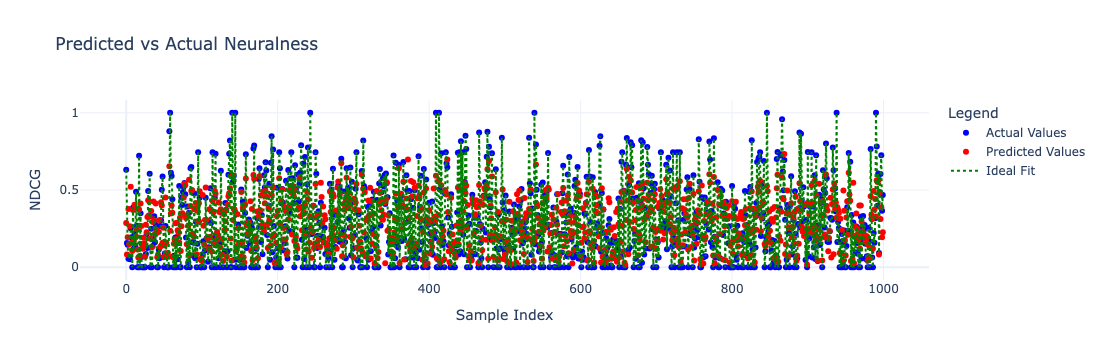

In [140]:
# Create a scatter plot for real values vs. predicted values
fig = go.Figure()

# Add actual values as a scatter trace
fig.add_trace(go.Scatter(
    x=list(range(len(y_test))),  # Index for x-axis
    y=y_test,
    mode='markers',
    name='Actual Values',
    marker=dict(color='blue')
))

# Add predicted values as a scatter trace
fig.add_trace(go.Scatter(
    x=list(range(len(y_pred))),  # Index for x-axis
    y=y_pred,
    mode='markers',
    name='Predicted Values',
    marker=dict(color='red')
))

# Add a line trace to indicate ideal predictions
fig.add_trace(go.Scatter(
    x=list(range(len(y_test))),
    y=y_test,  # For perfect alignment
    mode='lines',
    name='Ideal Fit',
    line=dict(color='green', dash='dot')
))

# Update layout for better readability
fig.update_layout(
    title="Predicted vs Actual Neuralness",
    xaxis_title="Sample Index",
    yaxis_title="NDCG",
    legend_title="Legend",
    template="plotly_white",
    showlegend=True
)

# Show the plot
fig.show()


In [141]:
# Store the test data for later usage
df_filtered.loc[df_filtered.index.isin(X_test.index)].to_csv('../data/dynamic_optimizer_large_qs_test_data-2024-12-03_DCG_fix.csv', index=False)

## Save Models

In [142]:
import pickle

with open('regression_model_predict_only_max_ndcg_large_qs-2024-12-03_DCG_fix.pkl', 'wb') as fid:
    pickle.dump(regr, fid) 

with open('random_forest_model_predict_only_max_ndcg_large_qs-2024-12-03_DCG_fix.pkl', 'wb') as fid:
    pickle.dump(model, fid) 